In [1]:
# Cell 1 — Regime-aware MoE (PyTorch) + IoU metric between Experts and Regimes

import math
import random
from typing import Tuple, Dict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


# ----------------------------
# Deterministic setup
# ----------------------------

def set_global_seed(seed: int = 42) -> None:
    """Set all relevant random seeds for reproducible experiments."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_global_seed(42)


# ----------------------------
# MLP Expert
# ----------------------------

class MLPExpert(nn.Module):
    """
    Simple MLP expert for scalar regression (e.g. Cd).
    You can adjust hidden_dim / depth as needed.
    """

    def __init__(self, in_dim: int, hidden_dim: int = 64, n_hidden: int = 2):
        super().__init__()
        layers = []
        last_dim = in_dim
        for _ in range(n_hidden):
            layers.append(nn.Linear(last_dim, hidden_dim))
            layers.append(nn.ReLU(inplace=True))
            last_dim = hidden_dim
        layers.append(nn.Linear(last_dim, 1))  # output: scalar Cd
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # shape: [batch, 1]
        return self.net(x)


# ----------------------------
# Gating + Regime Head
# ----------------------------

class GatingNetwork(nn.Module):
    """
    Shared gating network:
      - Outputs softmax over experts (gating probabilities)
      - Outputs logits over regimes (for regime classification head)
    """

    def __init__(
        self,
        in_dim: int,
        n_experts: int,
        n_regimes: int,
        hidden_dim: int = 64,
    ):
        super().__init__()
        self.n_experts = n_experts
        self.n_regimes = n_regimes

        # Shared trunk
        self.trunk = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(inplace=True),
        )

        # Heads
        self.gate_head = nn.Linear(hidden_dim, n_experts)
        self.regime_head = nn.Linear(hidden_dim, n_regimes)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returns:
          gate_probs: [batch, n_experts] (softmax)
          regime_logits: [batch, n_regimes]
        """
        h = self.trunk(x)
        gate_logits = self.gate_head(h)
        regime_logits = self.regime_head(h)
        gate_probs = F.softmax(gate_logits, dim=-1)
        return gate_probs, regime_logits


# ----------------------------
# MoE Surrogate Model (Regime-aware)
# ----------------------------

class MoECFDSurrogate(nn.Module):
    """
    Mixture-of-Experts surrogate for CFD with:
      - Multiple MLP experts for Cd regression
      - Gating network to mix experts
      - Regime classification head (for regime-aware loss)

    Forward returns:
      y_hat:          [batch]      (scalar Cd prediction)
      gate_probs:     [batch, E]   (gating probabilities)
      regime_logits:  [batch, R]   (logits for regime labels)
      expert_outputs: [batch, E]   (per-expert scalar outputs)
    """

    def __init__(
        self,
        in_dim: int,
        n_experts: int = 3,
        n_regimes: int = 3,
        expert_hidden_dim: int = 64,
        expert_n_hidden: int = 2,
        gate_hidden_dim: int = 64,
    ):
        super().__init__()
        self.n_experts = n_experts
        self.n_regimes = n_regimes

        # Experts
        self.experts = nn.ModuleList(
            [
                MLPExpert(
                    in_dim=in_dim,
                    hidden_dim=expert_hidden_dim,
                    n_hidden=expert_n_hidden,
                )
                for _ in range(n_experts)
            ]
        )

        # Gating + regime head
        self.gating = GatingNetwork(
            in_dim=in_dim,
            n_experts=n_experts,
            n_regimes=n_regimes,
            hidden_dim=gate_hidden_dim,
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        x: [batch, in_dim]

        Returns:
          y_hat:          [batch]      (mixture prediction)
          gate_probs:     [batch, E]
          regime_logits:  [batch, R]
          expert_outputs: [batch, E]   (raw expert predictions per sample)
        """
        gate_probs, regime_logits = self.gating(x)  # [B,E], [B,R]

        # Stack expert outputs: [E, B, 1] -> [B, E]
        expert_outputs = []
        for expert in self.experts:
            y_e = expert(x)  # [B,1]
            expert_outputs.append(y_e.squeeze(-1))  # [B]

        expert_outputs = torch.stack(expert_outputs, dim=1)  # [B, E]

        # Mixture prediction: weighted sum over experts
        # y_hat[b] = sum_e gate[b,e] * expert_outputs[b,e]
        y_hat = torch.sum(gate_probs * expert_outputs, dim=1)  # [B]

        return y_hat, gate_probs, regime_logits, expert_outputs


# ----------------------------
# Regime-aware loss function
# ----------------------------

def regime_aware_loss(
    y_hat: torch.Tensor,
    y_true: torch.Tensor,
    regime_logits: torch.Tensor,
    regime_true: torch.Tensor,
    lambda_reg: float = 0.5,
) -> Tuple[torch.Tensor, Dict[str, float]]:
    """
    Combined loss:
      L = MSE(Cd) + lambda_reg * CE(regime)

    Inputs:
      y_hat:         [batch]      predicted Cd
      y_true:        [batch]      true Cd
      regime_logits: [batch, R]   logits for regime classes
      regime_true:   [batch]      integer regime labels (0..R-1)
    """
    # Ensure shapes
    if y_hat.dim() != 1:
        y_hat = y_hat.view(-1)
    if y_true.dim() != 1:
        y_true = y_true.view(-1)

    mse = F.mse_loss(y_hat, y_true)
    ce = F.cross_entropy(regime_logits, regime_true)

    loss = mse + lambda_reg * ce
    stats = {
        "loss_total": float(loss.detach().cpu().item()),
        "loss_mse": float(mse.detach().cpu().item()),
        "loss_ce": float(ce.detach().cpu().item()),
    }
    return loss, stats


# ----------------------------
# IoU metric: Expert vs Regime
# ----------------------------

@torch.no_grad()
def compute_expert_regime_iou(
    gate_probs: torch.Tensor,
    regime_labels: torch.Tensor,
    num_experts: int,
    num_regimes: int,
    use_argmax: bool = True,
) -> torch.Tensor:
    """
    Compute IoU matrix between expert assignment and true regimes.

    Args:
      gate_probs:    [batch, E]  gating probabilities
      regime_labels: [batch]     integer regime labels 0..R-1
      num_experts:   E
      num_regimes:   R
      use_argmax:    if True, assign each sample to expert with max gate prob

    Returns:
      iou_matrix: [E, R]  where iou_matrix[e, r] = IoU(Expert e, Regime r)
    """
    assert gate_probs.dim() == 2, "gate_probs must be [batch, E]"
    assert regime_labels.dim() == 1, "regime_labels must be [batch]"

    device = gate_probs.device
    batch_size, E = gate_probs.shape
    R = num_regimes
    assert E == num_experts, "num_experts mismatch"
    assert regime_labels.shape[0] == batch_size, "batch size mismatch"

    # Expert assignment: [batch] in {0..E-1}
    if use_argmax:
        expert_assign = torch.argmax(gate_probs, dim=1)  # [B]
    else:
        # Alternative: sample from categorical; here keep deterministic with argmax
        expert_assign = torch.argmax(gate_probs, dim=1)

    iou = torch.zeros(E, R, device=device)

    for e in range(E):
        mask_e = (expert_assign == e)  # [B]
        count_e = mask_e.sum().item()
        if count_e == 0:
            # No samples assigned to this expert -> IoU = 0 for all regimes
            continue

        for r in range(R):
            mask_r = (regime_labels == r)  # [B]
            union_mask = mask_e | mask_r
            inter_mask = mask_e & mask_r

            inter = inter_mask.sum().item()
            union = union_mask.sum().item()

            if union == 0:
                iou[e, r] = 0.0
            else:
                iou[e, r] = inter / union

    return iou  # [E, R]

In [2]:
# Cell 2 — Synthetic CFD multi-regime dataset (X, y_cd, y_regime)

from typing import Dict
import numpy as np
import torch


def generate_fake_cfd_multi_regime(
    n_samples: int = 20000,
    val_ratio: float = 0.15,
    test_ratio: float = 0.15,
    device: torch.device | None = None,
) -> Dict[str, torch.Tensor]:
    """
    สร้าง synthetic CFD surrogate dataset แบบ multi-regime:

    Features X: [alpha_deg, log10Re, Mach]
    Targets:
      - y_cd:      Drag coefficient (scalar)
      - y_regime:  Regime label (0,1,2) ~ [attached, near-stall, post-stall]

    แบ่งเป็น train / val / test ตามสัดส่วนที่กำหนด
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    rng = np.random.default_rng(123)

    # ----------------------------
    # 1) Sample aerodynamic conditions
    # ----------------------------
    # มุมปะทะ [deg]
    alpha = rng.uniform(-5.0, 20.0, size=n_samples)     # angle of attack
    # Reynolds number (ใช้ log10 เพื่อ scale)
    logRe = rng.uniform(4.5, 6.5, size=n_samples)       # log10(Re)
    # Mach number
    mach = rng.uniform(0.1, 0.85, size=n_samples)

    # ----------------------------
    # 2) Assign regimes (A/B/C)
    # ----------------------------
    #  Regime 0: attached / cruise       (alpha < 8)
    #  Regime 1: near stall / nonlinear  (8 <= alpha < 14)
    #  Regime 2: post stall              (alpha >= 14)
    regime = np.zeros(n_samples, dtype=np.int64)
    regime[(alpha >= 8.0) & (alpha < 14.0)] = 1
    regime[alpha >= 14.0] = 2

    # ----------------------------
    # 3) Ground-truth Cd model (piecewise, nonlinear)
    # ----------------------------
    # Base drag: quadratic in alpha + weak Re/Mach dependence
    # ตั้งให้มีความโค้งพอสมควรเพื่อให้เห็นประโยชน์ของ MoE
    Re = 10.0 ** logRe
    Re_norm = Re / 1e6  # scale around 1

    base_cd = (
        0.02
        + 0.04 * (alpha / 10.0) ** 2          # main alpha^2 term
        + 0.01 * mach**2                      # compressibility effect
        + 0.015 * Re_norm ** (-0.2)           # Re dependency
    )

    # Regime-specific bump/behavior
    cd = base_cd.copy()

    # Regime 1: near stall bump (Gaussian around alpha ~ 11 deg)
    mask1 = (regime == 1)
    cd[mask1] += 0.15 * np.exp(-0.5 * ((alpha[mask1] - 11.0) / 2.0) ** 2)

    # Regime 2: strong drag growth post stall
    mask2 = (regime == 2)
    cd[mask2] += 0.4 + 0.05 * (alpha[mask2] - 14.0)

    # Add small Gaussian noise
    noise = rng.normal(loc=0.0, scale=0.01, size=n_samples)
    cd = cd + noise

    # ----------------------------
    # 4) Build feature matrix X
    # ----------------------------
    X = np.stack([alpha, logRe, mach], axis=1)  # [N, 3]

    # Optional: standardize features (ให้โมเดลเรียนง่ายขึ้น)
    feat_mean = X.mean(axis=0, keepdims=True)
    feat_std = X.std(axis=0, keepdims=True) + 1e-8
    X_norm = (X - feat_mean) / feat_std

    # ----------------------------
    # 5) Train / val / test split
    # ----------------------------
    idx = np.arange(n_samples)
    rng.shuffle(idx)

    n_val = int(n_samples * val_ratio)
    n_test = int(n_samples * test_ratio)
    n_train = n_samples - n_val - n_test

    idx_train = idx[:n_train]
    idx_val = idx[n_train : n_train + n_val]
    idx_test = idx[n_train + n_val :]

    def to_tensor(arr, idx_sub, dtype, device):
        return torch.as_tensor(arr[idx_sub], dtype=dtype, device=device)

    X_train = to_tensor(X_norm, idx_train, torch.float32, device)
    X_val   = to_tensor(X_norm, idx_val,   torch.float32, device)
    X_test  = to_tensor(X_norm, idx_test,  torch.float32, device)

    y_cd_train = to_tensor(cd, idx_train, torch.float32, device)
    y_cd_val   = to_tensor(cd, idx_val,   torch.float32, device)
    y_cd_test  = to_tensor(cd, idx_test,  torch.float32, device)

    y_reg_train = to_tensor(regime, idx_train, torch.long, device)
    y_reg_val   = to_tensor(regime, idx_val,   torch.long, device)
    y_reg_test  = to_tensor(regime, idx_test,  torch.long, device)

    meta = {
        "feature_names": ["alpha_deg", "log10Re", "Mach"],
        "regime_names": ["attached", "near_stall", "post_stall"],
        "feat_mean": torch.as_tensor(feat_mean.squeeze(0), dtype=torch.float32),
        "feat_std": torch.as_tensor(feat_std.squeeze(0), dtype=torch.float32),
    }

    return {
        "X_train": X_train,
        "X_val": X_val,
        "X_test": X_test,
        "y_cd_train": y_cd_train,
        "y_cd_val": y_cd_val,
        "y_cd_test": y_cd_test,
        "y_reg_train": y_reg_train,
        "y_reg_val": y_reg_val,
        "y_reg_test": y_reg_test,
        "meta": meta,
    }


# ลองสร้าง dataset และดู shape คร่าว ๆ
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = generate_fake_cfd_multi_regime(n_samples=20000, device=device)

for k in ["X_train", "X_val", "X_test", "y_cd_train", "y_reg_train"]:
    print(k, dataset[k].shape, dataset[k].dtype, dataset[k].device)

print("feature_names:", dataset["meta"]["feature_names"])
print("regime_names:", dataset["meta"]["regime_names"])

X_train torch.Size([14000, 3]) torch.float32 cpu
X_val torch.Size([3000, 3]) torch.float32 cpu
X_test torch.Size([3000, 3]) torch.float32 cpu
y_cd_train torch.Size([14000]) torch.float32 cpu
y_reg_train torch.Size([14000]) torch.int64 cpu
feature_names: ['alpha_deg', 'log10Re', 'Mach']
regime_names: ['attached', 'near_stall', 'post_stall']


In [3]:
# Cell 3 — สร้าง Regime-aware MoE model + train loop + IoU บน validation

import torch
import torch.nn.functional as F

# ---- 1) เตรียมตัวแปรพื้นฐาน ----

device = dataset["X_train"].device
in_dim = dataset["X_train"].shape[1]
n_experts = 3
n_regimes = 3

X_train = dataset["X_train"]
X_val   = dataset["X_val"]
y_cd_train = dataset["y_cd_train"]
y_cd_val   = dataset["y_cd_val"]
y_reg_train = dataset["y_reg_train"]
y_reg_val   = dataset["y_reg_val"]

print("Device:", device)
print("Input dim:", in_dim)


# ---- 2) สร้างโมเดล + optimizer ----

model = MoECFDSurrogate(
    in_dim=in_dim,
    n_experts=n_experts,
    n_regimes=n_regimes,
    expert_hidden_dim=64,
    expert_n_hidden=2,
    gate_hidden_dim=64,
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-5,
)

lambda_reg = 0.5
batch_size = 256
n_epochs = 40


# ---- 3) helper สำหรับทำ mini-batch ----

def iterate_minibatches(
    X: torch.Tensor,
    y_cd: torch.Tensor,
    y_reg: torch.Tensor,
    batch_size: int,
    shuffle: bool = True,
):
    """
    สร้าง minibatch จาก X, y_cd, y_reg แบบ simple
    """
    n = X.shape[0]
    idx = torch.arange(n, device=X.device)
    if shuffle:
        idx = idx[torch.randperm(n, device=X.device)]

    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        batch_idx = idx[start:end]
        yield X[batch_idx], y_cd[batch_idx], y_reg[batch_idx]


# ---- 4) Training loop ----

history = {
    "train_loss": [],
    "train_mse": [],
    "val_mse": [],
    "val_regime_acc": [],
}

for epoch in range(1, n_epochs + 1):
    model.train()
    epoch_loss = 0.0
    epoch_mse  = 0.0
    n_batches  = 0

    for xb, yb_cd, yb_reg in iterate_minibatches(
        X_train, y_cd_train, y_reg_train, batch_size=batch_size, shuffle=True
    ):
        optimizer.zero_grad()

        y_hat, gate_probs, regime_logits, expert_outputs = model(xb)
        loss, stats = regime_aware_loss(
            y_hat=y_hat,
            y_true=yb_cd,
            regime_logits=regime_logits,
            regime_true=yb_reg,
            lambda_reg=lambda_reg,
        )

        loss.backward()
        optimizer.step()

        epoch_loss += stats["loss_total"]
        epoch_mse  += stats["loss_mse"]
        n_batches  += 1

    epoch_loss /= max(n_batches, 1)
    epoch_mse  /= max(n_batches, 1)
    history["train_loss"].append(epoch_loss)
    history["train_mse"].append(epoch_mse)

    # ---- validation ----
    model.eval()
    with torch.no_grad():
        y_val_hat, gate_probs_val, regime_logits_val, exp_out_val = model(X_val)
        val_mse = F.mse_loss(y_val_hat, y_cd_val).item()
        val_regime_pred = regime_logits_val.argmax(dim=1)
        val_regime_acc = (val_regime_pred == y_reg_val).float().mean().item()

        history["val_mse"].append(val_mse)
        history["val_regime_acc"].append(val_regime_acc)

        # IoU matrix ระหว่าง expert assignment และ regime จริง
        iou_mat = compute_expert_regime_iou(
            gate_probs=gate_probs_val,
            regime_labels=y_reg_val,
            num_experts=n_experts,
            num_regimes=n_regimes,
            use_argmax=True,
        )

    if epoch % 5 == 0 or epoch == 1 or epoch == n_epochs:
        print(
            f"Epoch {epoch:3d} | "
            f"train_loss={epoch_loss:.4f} "
            f"train_mse={epoch_mse:.4f} "
            f"val_mse={val_mse:.4f} "
            f"val_regime_acc={val_regime_acc:.3f}"
        )

# ---- 5) แสดง IoU matrix สุดท้ายแบบอ่านง่าย ----

regime_names = dataset["meta"]["regime_names"]
print("\nFinal IoU matrix (Experts x Regimes):")
for e in range(n_experts):
    row_vals = [f"{float(iou_mat[e, r]):.3f}" for r in range(n_regimes)]
    print(f" Expert {e}: " + "  ".join(
        f"{regime_names[r]}={row_vals[r]}" for r in range(n_regimes)
    ))

# หา regime ที่ expert แต่ละตัว specialize สูงสุด
print("\nBest regime per expert (by IoU):")
for e in range(n_experts):
    r_best = int(torch.argmax(iou_mat[e]).item())
    print(f" Expert {e} -> {regime_names[r_best]} (IoU={float(iou_mat[e, r_best]):.3f})")

Device: cpu
Input dim: 3
Epoch   1 | train_loss=0.3804 train_mse=0.0339 val_mse=0.0053 val_regime_acc=0.864
Epoch   5 | train_loss=0.0389 train_mse=0.0023 val_mse=0.0023 val_regime_acc=0.986
Epoch  10 | train_loss=0.0192 train_mse=0.0012 val_mse=0.0011 val_regime_acc=0.992
Epoch  15 | train_loss=0.0135 train_mse=0.0008 val_mse=0.0008 val_regime_acc=0.993
Epoch  20 | train_loss=0.0110 train_mse=0.0007 val_mse=0.0007 val_regime_acc=0.994
Epoch  25 | train_loss=0.0089 train_mse=0.0005 val_mse=0.0006 val_regime_acc=0.993
Epoch  30 | train_loss=0.0079 train_mse=0.0005 val_mse=0.0005 val_regime_acc=0.994
Epoch  35 | train_loss=0.0074 train_mse=0.0005 val_mse=0.0005 val_regime_acc=0.996
Epoch  40 | train_loss=0.0066 train_mse=0.0004 val_mse=0.0005 val_regime_acc=0.994

Final IoU matrix (Experts x Regimes):
 Expert 0: attached=0.838  near_stall=0.000  post_stall=0.000
 Expert 1: attached=0.000  near_stall=0.009  post_stall=0.982
 Expert 2: attached=0.111  near_stall=0.732  post_stall=0.000

Be

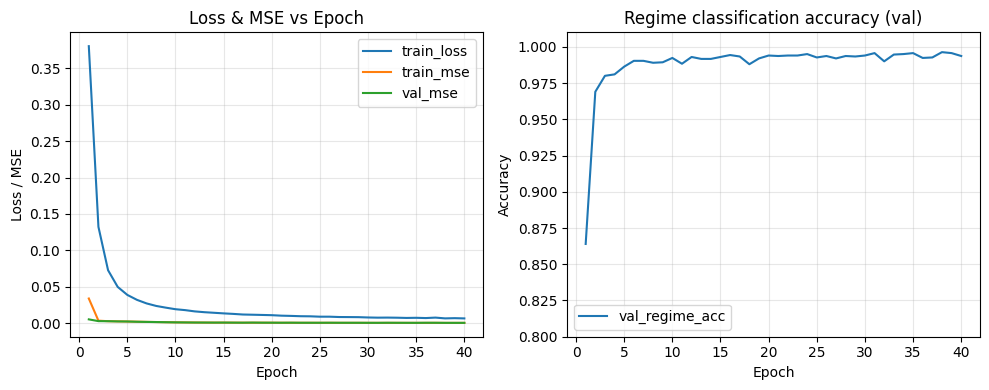

In [4]:
# Cell 4 — Plot learning curves ของ Regime-aware MoE (λ=0.5, E=3)

import matplotlib.pyplot as plt

epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(10, 4))

# --- Plot 1: Loss + MSE ---
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="train_loss")
plt.plot(epochs, history["train_mse"], label="train_mse")
plt.plot(epochs, history["val_mse"],   label="val_mse")
plt.xlabel("Epoch")
plt.ylabel("Loss / MSE")
plt.title("Loss & MSE vs Epoch")
plt.grid(True, alpha=0.3)
plt.legend()

# --- Plot 2: Regime accuracy ---
plt.subplot(1, 2, 2)
plt.plot(epochs, history["val_regime_acc"], label="val_regime_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.8, 1.01)
plt.title("Regime classification accuracy (val)")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

In [5]:
# Cell 5 — Ablation: sweep lambda_reg และ n_experts

def train_regime_aware_moe(
    n_experts: int,
    lambda_reg: float,
    n_epochs: int = 25,
    batch_size: int = 256,
    verbose: bool = False,
):
    """
    Train Regime-aware MoE หนึ่งรอบสำหรับ config ที่กำหนด
    คืน:
      - best_val_mse
      - final_val_mse
      - final_iou (tensor [E, R])
      - history (dict)
    """
    # ให้แต่ละ run deterministic
    set_global_seed(42)

    model = MoECFDSurrogate(
        in_dim=in_dim,
        n_experts=n_experts,
        n_regimes=n_regimes,
        expert_hidden_dim=64,
        expert_n_hidden=2,
        gate_hidden_dim=64,
    ).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

    hist = {
        "train_loss": [],
        "train_mse": [],
        "val_mse": [],
        "val_regime_acc": [],
    }

    best_val_mse = float("inf")
    best_epoch = -1
    final_iou = None

    for epoch in range(1, n_epochs + 1):
        model.train()
        epoch_loss = 0.0
        epoch_mse = 0.0
        n_batches = 0

        for xb, yb_cd, yb_reg in iterate_minibatches(
            X_train, y_cd_train, y_reg_train,
            batch_size=batch_size,
            shuffle=True,
        ):
            opt.zero_grad()
            y_hat, gate_probs, regime_logits, exp_out = model(xb)
            loss, stats = regime_aware_loss(
                y_hat=y_hat,
                y_true=yb_cd,
                regime_logits=regime_logits,
                regime_true=yb_reg,
                lambda_reg=lambda_reg,
            )
            loss.backward()
            opt.step()

            epoch_loss += stats["loss_total"]
            epoch_mse  += stats["loss_mse"]
            n_batches  += 1

        epoch_loss /= max(n_batches, 1)
        epoch_mse  /= max(n_batches, 1)
        hist["train_loss"].append(epoch_loss)
        hist["train_mse"].append(epoch_mse)

        # --- validation ---
        model.eval()
        with torch.no_grad():
            y_val_hat, gate_probs_val, regime_logits_val, exp_out_val = model(X_val)
            val_mse = F.mse_loss(y_val_hat, y_cd_val).item()
            val_reg_pred = regime_logits_val.argmax(dim=1)
            val_reg_acc = (val_reg_pred == y_reg_val).float().mean().item()
            hist["val_mse"].append(val_mse)
            hist["val_regime_acc"].append(val_reg_acc)

            iou_mat = compute_expert_regime_iou(
                gate_probs=gate_probs_val,
                regime_labels=y_reg_val,
                num_experts=n_experts,
                num_regimes=n_regimes,
                use_argmax=True,
            )

        if val_mse < best_val_mse:
            best_val_mse = val_mse
            best_epoch = epoch
            # copy iou_mat เก็บไว้ตอนที่ดีที่สุด
            final_iou = iou_mat.clone()

        if verbose and (epoch % 5 == 0 or epoch == 1 or epoch == n_epochs):
            print(
                f"[E={n_experts}, λ={lambda_reg}] "
                f"epoch {epoch:2d}: train_loss={epoch_loss:.4f}, "
                f"val_mse={val_mse:.4e}, val_reg_acc={val_reg_acc:.3f}"
            )

    return {
        "best_val_mse": best_val_mse,
        "final_val_mse": hist["val_mse"][-1],
        "best_epoch": best_epoch,
        "iou": final_iou,
        "history": hist,
    }


# ---- รัน sweep: λ และ n_experts ----

lambda_list = [0.0, 0.1, 0.5, 1.0]
n_expert_list = [2, 3, 5]

results = {}

print("=== Ablation: n_experts x lambda_reg ===")
for E in n_expert_list:
    for lam in lambda_list:
        res = train_regime_aware_moe(
            n_experts=E,
            lambda_reg=lam,
            n_epochs=25,
            batch_size=256,
            verbose=False,
        )
        iou = res["iou"]
        # คำนวณ IoU เฉลี่ยของ "best regime per expert"
        best_iou_per_expert = []
        for e in range(E):
            best_iou_per_expert.append(float(iou[e].max().item()))
        avg_best_iou = float(np.mean(best_iou_per_expert))

        results[(E, lam)] = {
            "best_val_mse": res["best_val_mse"],
            "avg_best_iou": avg_best_iou,
        }

        print(
            f"E={E}, λ={lam:>3} | "
            f"best_val_mse={res['best_val_mse']:.4e} | "
            f"avg_best_IoU={avg_best_iou:.3f}"
        )

# ถ้าอยากดู config ที่ดีที่สุดตาม MSE และตาม IoU:
best_by_mse = min(results.items(), key=lambda kv: kv[1]["best_val_mse"])
best_by_iou = max(results.items(), key=lambda kv: kv[1]["avg_best_iou"])

print("\nBest config by val MSE:")
print(" (E, λ) =", best_by_mse[0], "=>", best_by_mse[1])

print("\nBest config by avg best-IoU:")
print(" (E, λ) =", best_by_iou[0], "=>", best_by_iou[1])

=== Ablation: n_experts x lambda_reg ===
E=2, λ=0.0 | best_val_mse=9.4157e-04 | avg_best_IoU=0.723
E=2, λ=0.1 | best_val_mse=6.6899e-04 | avg_best_IoU=0.729
E=2, λ=0.5 | best_val_mse=7.6411e-04 | avg_best_IoU=0.808
E=2, λ=1.0 | best_val_mse=9.1202e-04 | avg_best_IoU=0.815
E=3, λ=0.0 | best_val_mse=6.8158e-04 | avg_best_IoU=0.550
E=3, λ=0.1 | best_val_mse=5.9104e-04 | avg_best_IoU=0.927
E=3, λ=0.5 | best_val_mse=5.9960e-04 | avg_best_IoU=0.864
E=3, λ=1.0 | best_val_mse=6.0988e-04 | avg_best_IoU=0.908
E=5, λ=0.0 | best_val_mse=7.5284e-04 | avg_best_IoU=0.104
E=5, λ=0.1 | best_val_mse=5.0475e-04 | avg_best_IoU=0.561
E=5, λ=0.5 | best_val_mse=5.2090e-04 | avg_best_IoU=0.567
E=5, λ=1.0 | best_val_mse=5.2265e-04 | avg_best_IoU=0.570

Best config by val MSE:
 (E, λ) = (5, 0.1) => {'best_val_mse': 0.0005047518061473966, 'avg_best_iou': 0.5611807070672512}

Best config by avg best-IoU:
 (E, λ) = (3, 0.1) => {'best_val_mse': 0.0005910355830565095, 'avg_best_iou': 0.927372395992279}


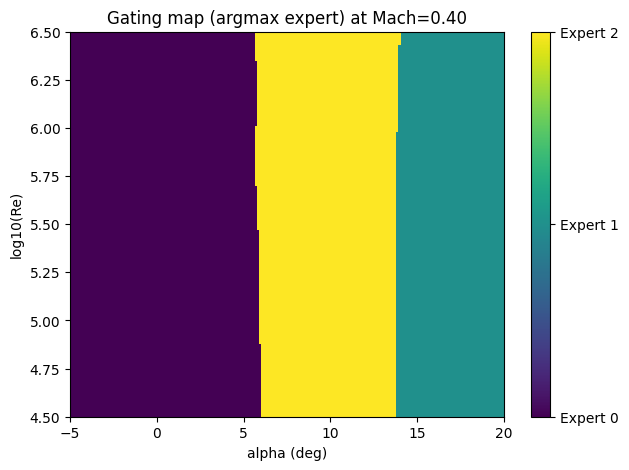

In [6]:
# Cell 6 — 2D gating map (alpha_deg vs log10Re), fix Mach

import numpy as np
import matplotlib.pyplot as plt

model.eval()

meta = dataset["meta"]
feat_mean = meta["feat_mean"].to(device)  # [3]
feat_std  = meta["feat_std"].to(device)   # [3]

# สร้าง grid ใน space จริง
alpha_min, alpha_max = -5.0, 20.0
logRe_min, logRe_max = 4.5, 6.5
mach_fixed = 0.4  # เลือก Mach ค่าหนึ่งกลางๆ

n_alpha = 200
n_logRe = 200

alpha_grid = np.linspace(alpha_min, alpha_max, n_alpha)
logRe_grid = np.linspace(logRe_min, logRe_max, n_logRe)

AA, RR = np.meshgrid(alpha_grid, logRe_grid, indexing="ij")  # [n_alpha, n_logRe]

# stack features: [N, 3]
X_phys = np.stack(
    [AA.ravel(), RR.ravel(), np.full_like(AA.ravel(), mach_fixed)],
    axis=1
)  # [N, 3]

# normalize
X_norm = (torch.as_tensor(X_phys, dtype=torch.float32, device=device) - feat_mean) / feat_std

with torch.no_grad():
    _, gate_probs_grid, _, _ = model(X_norm)  # [N, E]
    expert_assign_grid = torch.argmax(gate_probs_grid, dim=1).view(n_alpha, n_logRe).cpu().numpy()

# plot
plt.figure(figsize=(7, 5))
im = plt.imshow(
    expert_assign_grid.T,   # transpose ให้แกน x,y ตรงกับ alpha/logRe
    origin="lower",
    extent=[alpha_min, alpha_max, logRe_min, logRe_max],
    aspect="auto",
    interpolation="nearest",
)
cbar = plt.colorbar(im, ticks=range(n_experts))
cbar.ax.set_yticklabels([f"Expert {e}" for e in range(n_experts)])

plt.xlabel("alpha (deg)")
plt.ylabel("log10(Re)")
plt.title(f"Gating map (argmax expert) at Mach={mach_fixed:.2f}")
plt.grid(False)
plt.show()

=== Per-regime error (true regimes, on test set) ===
Regime 0 (attached): N=1607 | MSE=1.2469e-04 | MAE=8.7775e-03 | regime_acc=0.995
Regime 1 (near_stall): N= 705 | MSE=9.1646e-04 | MAE=1.4743e-02 | regime_acc=0.996
Regime 2 (post_stall): N= 688 | MSE=8.1437e-04 | MAE=1.5808e-02 | regime_acc=0.993


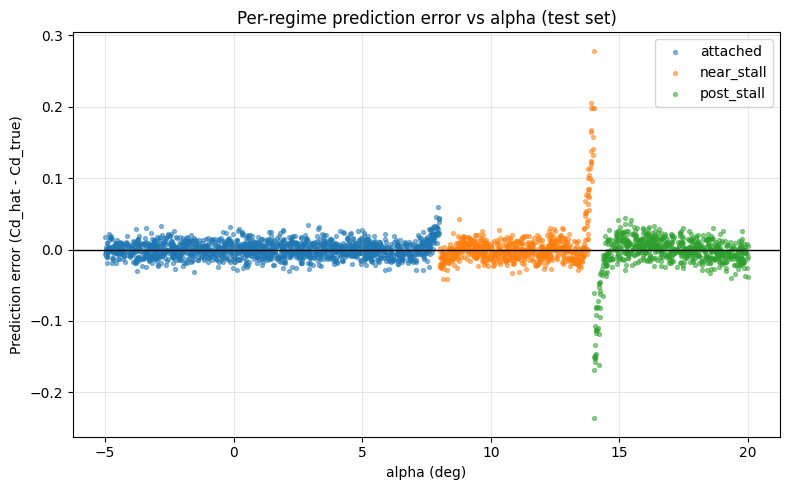

In [7]:
# Cell 8 — Per-regime error analysis บน test set

model.eval()
X_test      = dataset["X_test"]
y_cd_test   = dataset["y_cd_test"]
y_reg_test  = dataset["y_reg_test"]

with torch.no_grad():
    y_hat_test, gate_probs_test, regime_logits_test, _ = model(X_test)
    regime_pred_test = torch.argmax(regime_logits_test, dim=1)

# helper metric
def mse(x, y):
    return float(F.mse_loss(x, y).item())

def mae(x, y):
    return float(torch.mean(torch.abs(x - y)).item())

regime_names = dataset["meta"]["regime_names"]

print("=== Per-regime error (true regimes, on test set) ===")
for r in range(n_regimes):
    mask = (y_reg_test == r)
    n_r = int(mask.sum().item())
    if n_r == 0:
        continue

    y_true_r = y_cd_test[mask]
    y_hat_r  = y_hat_test[mask]

    mse_r = mse(y_hat_r, y_true_r)
    mae_r = mae(y_hat_r, y_true_r)

    # regime classification accuracy เฉพาะใน regime นี้
    reg_pred_r = regime_pred_test[mask]
    reg_acc_r = float((reg_pred_r == r).float().mean().item())

    print(
        f"Regime {r} ({regime_names[r]}): "
        f"N={n_r:4d} | MSE={mse_r:.4e} | MAE={mae_r:.4e} | "
        f"regime_acc={reg_acc_r:.3f}"
    )

# Optional: error vs alpha plot per regime
X_test_norm = X_test.cpu()
X_test_phys = X_test_norm * feat_std.cpu() + feat_mean.cpu()
alpha_test  = X_test_phys[:, 0].numpy()
err_test    = (y_hat_test - y_cd_test).detach().cpu().numpy()

plt.figure(figsize=(8, 5))
for r in range(n_regimes):
    mask = (y_reg_test.cpu().numpy() == r)
    plt.scatter(
        alpha_test[mask],
        err_test[mask],
        s=8,
        alpha=0.5,
        label=f"{regime_names[r]}",
    )

plt.axhline(0.0, color="k", linewidth=1)
plt.xlabel("alpha (deg)")
plt.ylabel("Prediction error (Cd_hat - Cd_true)")
plt.title("Per-regime prediction error vs alpha (test set)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()